In [1]:
import torch 
from torch import nn
import torch.nn.functional as F

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests

In [2]:
!export PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0  # Adjust the ratio as needed


# Attention workflow
1. Input 
2. Word embeddings
3. Positional embeddings
4. Concat(Word, Positional)
5. Normalization (optional)
6. Attention


In [3]:
n_embd=128
n_head=4
num_layers = 4
block_size=512
vocab_size=100
dropout=0.1

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

class Data:
    def __init__(self, path, data_url, create_split: bool = True):
        """
        Initialize the Download class.
        
        :param path: The path where the data will be saved.
        :param data_url: The URL to download the data from.
        :param create_split: Whether to create train/validation split.
        """
        self.path = path
        self.data_url = data_url
        self.create_split = create_split

    def dowload(self):
        """
        Fetch the data from the specified URL and save it to the specified path.
        """
        try:
            # Create the 'data' directory relative to the current directory
            data_dir = os.path.join(os.getcwd(), 'data')
            os.makedirs(data_dir, exist_ok=True)

            # Construct the full file path
            input_file_path = os.path.join(data_dir, self.path)

            # Download the file if it doesn't exist
            if not os.path.exists(input_file_path):
                response = requests.get(self.data_url)
                response.raise_for_status()  # Raise an error for bad status codes
                with open(input_file_path, 'w') as f:
                    f.write(response.text)

            # Read and print the length of the dataset
            with open(input_file_path, 'r') as f:
                self.data = f.read()
            print(f"Length of dataset in characters: {len(self.data):,}")
            self.preprocessing()
        except requests.exceptions.RequestException as e:
            print(f"Error downloading the file: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    def preprocessing(self, X = None, inference=True):
        """
        Preprocess the data to create character mappings and encoding functions.
        """
        # Get all the unique characters that occur in this text
        chars = sorted(list(set(self.data)))
        vocab_size = len(chars)
        print("All the unique characters:", ''.join(chars))
        print(f"Vocab size: {vocab_size:,}")

        # Create a mapping from characters to integers
        stoi = {ch: i for i, ch in enumerate(chars)}
        itos = {i: ch for i, ch in enumerate(chars)}

        self.encode = lambda s: [stoi[c] for c in s]
        self.decode = lambda l: ''.join([itos[i] for i in l]) 
        if inference:
            self.encode(X)

    def split(self, size=0.9):
        """
        Create train and validation splits from the data.
        
        :param size: The proportion of data to use for training.
        :return: Encoded training and validation data.
        """
        n = len(self.data)
        train_data = self.data[:int(n * size)]
        val_data = self.data[int(n * size):]  

        # Encoding
        train_ids = self.encode(train_data)
        val_ids = self.encode(val_data)
        print(f"Train has {len(train_ids):,} tokens")
        print(f"Val has {len(val_ids):,} tokens")

        return train_ids, val_ids
    
    def get_batch(self, train_ids=None, val_ids=None, split: str = 'train', context_len: int = 1024, batch_size: int = 8, device_type: str = 'mps', device: str = 'mps'):
        """
        Generate batches of data for training or validation.
        
        :param train_ids: Encoded training data.
        :param val_ids: Encoded validation data.
        :param split: Whether to use 'train' or 'val' data.
        :param context_len: Length of the context for each sample.
        :param batch_size: Number of samples per batch.
        :param device_type: Type of device ('cuda' or other).
        :param device: Specific device identifier.
        :return: Batch of input and target data.
        """
        data = train_ids if split == 'train' else val_ids
        print(f"Preparing {split} batch")

        ix = torch.randint(len(data) - context_len, (batch_size,))
        x = torch.stack([torch.tensor(data[i:i + context_len]) for i in ix])
        y = torch.stack([torch.tensor(data[i + 1:i + 1 + context_len]) for i in ix])
        
        if device_type == 'cuda':
            # Pin arrays x, y, which allows us to move them to GPU asynchronously (non_blocking=True)
            x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
        else:
            x, y = x.to(device), y.to(device)
        return x, y

# Example usage:
input_file = 'tiny_shakespeare.txt'
URL = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

downloader = Data(input_file, URL)
downloader.dowload()
train_ids, val_ids = downloader.split()
x, y = downloader.get_batch(train_ids=train_ids)


Length of dataset in characters: 1,115,394
All the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size: 65
An error occurred: 'NoneType' object is not iterable
Train has 1,003,854 tokens
Val has 111,540 tokens
Preparing train batch


In [5]:
#embedding block
class Embeddings(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, device):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, n_embd).to(device)
        self.wpe = nn.Embedding(block_size, n_embd).to(device)

    def forward(self, x):
        b, t = x.size()
        pos = torch.arange(0, t, dtype=torch.long, device=x.device)
        T = self.wte(x)
        P = self.wpe(pos).unsqueeze(0).expand(b, t, -1)
        return T+P

In [6]:
#feed forward and tranformer blocks
class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, attention, n_embd, n_head, dropout, block_size, device, 
                 sparse:bool=False, sparsity_pattern=None):
        super().__init__()
        if sparse:
            self.attn = attention(n_embd, n_head, dropout, block_size, sparsity_pattern, device)
        else:
            self.attn = attention(n_embd, n_head, dropout, block_size, device)
        self.ff = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        attn_output, attn_weights = self.attn(self.ln1(x))
        x = x + attn_output
        x = x + self.ff(self.ln2(x))
        return x, attn_weights

class TransformerModel(nn.Module):
    def __init__(self, attention, vocab_size, 
                 n_embd, 
                 n_head, 
                 num_layers, 
                 dropout, 
                 block_size, 
                 device,
                 sparse=False,
                 sparsity_pattern=None 
                 ):
        super().__init__()
        self.embeddings = Embeddings(vocab_size, n_embd, block_size, device)
        self.blocks = nn.Sequential(*[TransformerBlock(attention, n_embd, n_head, dropout, block_size, 
                                                       device, sparse, sparsity_pattern) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

    def forward(self, x):
        x = self.embeddings(x)
        attn_weights_all = []
        for block in self.blocks:
            x, attn_weights = block(x)
            attn_weights_all.append(attn_weights)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, attn_weights_all

In [13]:
#casual attention
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, device):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.block_size = block_size

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        att_y = att @ v
        y = att_y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y, att


In [14]:
# Example usage
casual_transformer = TransformerModel(attention = CausalSelfAttention, 
                                      vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device,
                                      sparse=False,
                                      sparsity_pattern=None,
                                      ).to(device)

In [15]:
import time
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, x, y, num_epochs, learning_rate=0.0001):
    dataloader = DataLoader(TensorDataset(x, y), shuffle=True)
    model = model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    start_time = time.time()

    step_loss = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            outputs, attn_weights = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            step_loss.append(loss.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}')

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training completed in {training_time:.2f} seconds')

    return step_loss, attn_weights

In [16]:
# Run experiments
epoch_loss = train_model(casual_transformer, x,y, num_epochs=200)


Epoch 1/200, Loss: 4.566704154014587
Epoch 2/200, Loss: 4.132993757724762
Epoch 3/200, Loss: 3.8539985716342926
Epoch 4/200, Loss: 3.686150074005127
Epoch 5/200, Loss: 3.555873602628708
Epoch 6/200, Loss: 3.4627455174922943
Epoch 7/200, Loss: 3.3987650275230408
Epoch 8/200, Loss: 3.349842071533203
Epoch 9/200, Loss: 3.2984902262687683
Epoch 10/200, Loss: 3.2449457347393036
Epoch 11/200, Loss: 3.2053700387477875
Epoch 12/200, Loss: 3.1796063482761383
Epoch 13/200, Loss: 3.154375821352005
Epoch 14/200, Loss: 3.111363798379898
Epoch 15/200, Loss: 3.0550367534160614
Epoch 16/200, Loss: 3.017396569252014
Epoch 17/200, Loss: 3.0095189213752747
Epoch 18/200, Loss: 3.0031802356243134
Epoch 19/200, Loss: 2.957880437374115
Epoch 20/200, Loss: 2.902564913034439
Epoch 21/200, Loss: 2.90509495139122
Epoch 22/200, Loss: 2.941989243030548
Epoch 23/200, Loss: 2.937266021966934
Epoch 24/200, Loss: 2.888759434223175
Epoch 25/200, Loss: 2.8644835352897644
Epoch 26/200, Loss: 2.8796295821666718
Epoch 27/2

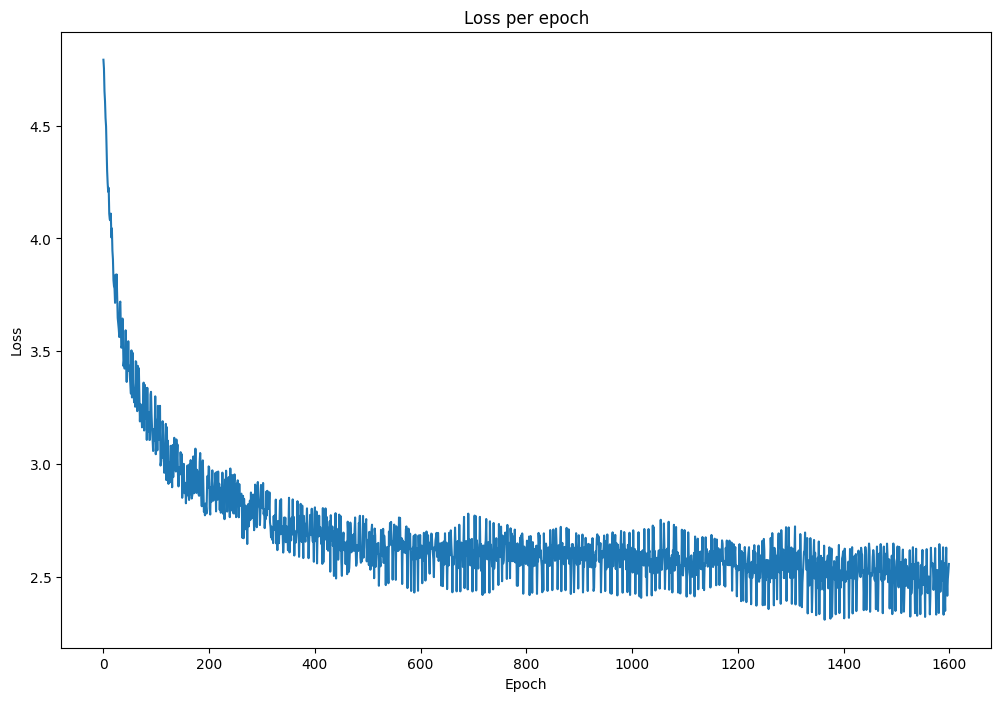

In [29]:
plt.figure(figsize=(12,8))
sns.lineplot(np.array(epoch_loss[:-1])[0])
plt.title(f'Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [38]:
text = 'hi'
text = downloader.encode(text)
text = torch.Tensor(text)

logits = casual_transformer(text.long().unsqueeze(0).to(device))
downloader.decode(F.softmax(logits[0], dim=-1).argmax(-1).detach().cpu().numpy()[0])

'et'

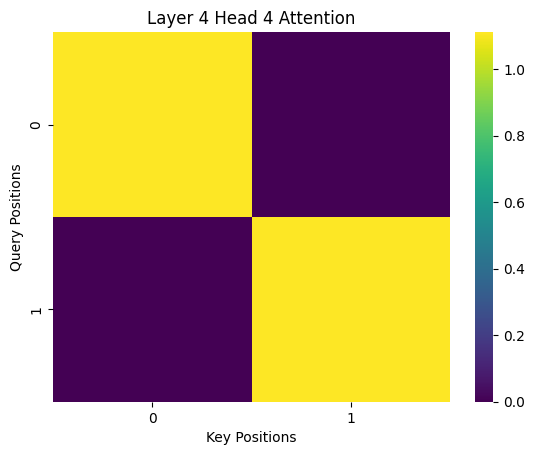

In [49]:
sns.heatmap(logits[1][1][0][0].cpu().detach().numpy(), cmap="viridis")
plt.title(f'Layer {num_layers} Head {n_head} Attention')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()

In [ ]:
#flash attention
class FlashAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, device):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.block_size = block_size

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Flash Attention computation
        q = q / math.sqrt(C // self.n_head)  # Scaling
        attn_weights = torch.einsum('bhqd, bhkd -> bhqk', q, k)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        y = torch.einsum('bhqk, bhvd -> bhqd', attn_weights, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y


# Example usage
flash_transformer = TransformerModel(attention = FlashAttention, 
                                      vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device,
                                      sparse=False,
                                      sparsity_pattern=None,
                                      ).to(device)
flash_logits = flash_transformer(x)

print(flash_logits.size())

In [ ]:
# SparseAttention block
class SparseAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, device, sparsity_pattern=None):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.block_size = block_size
        self.sparsity_pattern = sparsity_pattern

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Sparse Attention computation
        attn_weights = torch.einsum('bhqd, bhkd -> bhqk', q, k) / math.sqrt(C // self.n_head)
        
        if self.sparsity_pattern is not None:
            attn_weights = attn_weights.masked_fill(self.sparsity_pattern == 0, -1e9)
        
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        y = torch.einsum('bhqk, bhvd -> bhqd', attn_weights, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y


# Define a sparsity pattern (example: attend to only a subset of tokens)
sparsity_pattern = torch.ones(1, 12, 100, 100, device=device)  # Modify this pattern as needed
# For example, you can create a block sparsity pattern
for i in range(0, 100, 8):
    for j in range(0, 100, 8):
        if (i // 8 + j // 8) % 2 == 0:
            sparsity_pattern[:, :, i:i+8, j:j+8] = 0

# Sample input

# Instantiate and run the model
sparse_transformer = TransformerModel(SparseAttention, 
                                      sparse=True, 
                                      sparsity_pattern=sparsity_pattern, 
                                      vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device).to(device)
sparse_logits = sparse_transformer(x)

print(sparse_logits.size())

In [ ]:
x.shape

In [ ]:
n_embd=128
n_head=4
num_layers = 4
block_size=512
vocab_size=100
dropout=0.1

In [ ]:
class LocalAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, window_size, device):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.window_size = window_size

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        output = []
        for i in range(T):
            start = max(0, i - self.window_size)
            end = min(T, i + self.window_size)
            q_i = q[:, :, i, :]
            k_i = k[:, :, start:end, :]
            v_i = v[:, :, start:end, :]

            attn_weights = torch.einsum('bhd,bhjd->bhj', q_i, k_i) / math.sqrt(C // self.n_head)
            attn_weights = F.softmax(attn_weights, dim=-1)
            attn_weights = self.attn_dropout(attn_weights)

            context = torch.einsum('bhj,bhjd->bhd', attn_weights, v_i)
            output.append(context)

        output = torch.stack(output, dim=2).transpose(1, 2).contiguous().view(B, T, C)
        output = self.resid_dropout(self.c_proj(output))
        return output

# Example usage
local_transformer = TransformerModel(attention=LocalAttention, 
                                     vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device,
                                      sparse=False,
                                      sparsity_pattern=None,
                                      ).to(device)
local_logits = local_transformer(x)

print(local_logits.size())
